In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import numpy as np
import keras

import sys
sys.path.append("scripts")
import utils
from PET import PET

import matplotlib.pyplot as plt

2024-05-03 15:14:25.704471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 15:14:25.704494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 15:14:25.704520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 15:14:25.710123: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.run_functions_eagerly(False)

In [3]:
import awkward
import vector

def to_p4(p4_obj):
    return vector.awk(
        awkward.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )

def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

In [4]:
model = PET(
    num_feat=13,
    num_jet=4,
    num_classes=10,
    local=True,
    num_layers=8,
    drop_probability=0,
    simple=False,
    layer_scale=True,
    talking_head=False,
    mode="all"
)

2024-05-03 15:14:29.543405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 15:14:29.551605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 15:14:29.553018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
x = {}
x["input_features"] = tf.zeros((32, 100, 13))
x["input_points"] = tf.zeros((32, 100, 2))
x["input_mask"] = tf.zeros((32, 100))
x["input_jet"] = tf.zeros((32, 4))
x["input_time"] = tf.zeros((32, 1))

model(x)
out = model.body(x)
print(len(out), out.shape)

32 (32, 100, 128)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['input_jet'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [6]:
model.summary()
model.load_weights("checkpoints/PET_jetclass_8_local_layer_scale_token_baseline_all.weights.h5", by_name=True)

Model: "pet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PET_body (Functional)       (None, None, 128)         1318784   
                                                                 
 classifier_head (Functiona  [(None, 10),              269326    
 l)                           (None, 4)]                         
                                                                 
 generator_head (Functional  (None, None, 13)          417165    
 )                                                               
                                                                 
 classifier (Functional)     [(None, 10),              1588110   
                              (None, 4)]                         
                                                                 
 generator (Functional)      (None, None, 13)          1735949   
                                                               

In [7]:
data = awkward.from_parquet("../ml-tau-en-reg/data/zh.parquet")

In [8]:
reco_cand_p4s = to_p4(data["reco_cand_p4s"])
reco_jet_p4s = to_p4(data["reco_jet_p4s"])

delta_eta = reco_cand_p4s.eta - reco_jet_p4s.eta
delta_phi = deltaphi(reco_cand_p4s.phi, reco_jet_p4s.phi)
log_pt = np.log(reco_cand_p4s.pt)
log_e = np.log(reco_cand_p4s.energy)
log_ptjet = np.log(1 - reco_cand_p4s.pt/reco_jet_p4s.pt)
log_ejet = np.log(1 - reco_cand_p4s.energy/reco_jet_p4s.energy)
delta_r = deltar(reco_cand_p4s.eta, reco_cand_p4s.phi, reco_jet_p4s.eta, reco_jet_p4s.phi)
charge = data["reco_cand_charge"]
is_ele = np.abs(data["reco_cand_pdg"])==11
is_mu = np.abs(data["reco_cand_pdg"])==13
is_photon = np.abs(data["reco_cand_pdg"])==22
is_chhad = np.abs(data["reco_cand_pdg"])==210
is_nhad = np.abs(data["reco_cand_pdg"])==130

/usr/local/lib/python3.10/dist-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: divide by zero encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))
/usr/local/lib/python3.10/dist-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in log
  return impl(*broadcasted_args, **(kwargs or {}))


In [9]:
pad_size = 64 #max number of particles per jet
fill_val = 0 #fill value of padded data

#create particle array in the shape [njets, pad_size, 13]
vals = [
    awkward.to_numpy(
        awkward.fill_none(
            awkward.pad_none(
                x, pad_size, clip=True), fill_val
        )
    ) for x in [delta_eta, delta_phi, log_pt, log_e, log_ptjet, log_ejet, delta_r, charge, is_ele, is_mu, is_photon, is_chhad, is_nhad]
]
particles = np.stack(vals, axis=-1)
particles[np.isnan(particles)] = 0
particles[np.isinf(particles)] = 0
particles_mask = (~awkward.to_numpy(awkward.pad_none(delta_eta, pad_size, clip=True)).mask).astype(np.float32)

#normalize particles
means_particle = particles[np.squeeze(particles_mask==1)].mean(axis=0)
stds_particle = particles[np.squeeze(particles_mask==1)].std(axis=0)
stds_particle[stds_particle==0] = 1
particles = (particles - means_particle)/stds_particle

#create jet array in the shape [njets, 4]
jets = awkward.to_numpy(np.stack([
    reco_jet_p4s.pt,
    reco_jet_p4s.eta,
    reco_jet_p4s.mass,
    awkward.num(reco_cand_p4s)], axis=-1)
)
jets[np.isnan(jets)] = 0
jets[np.isinf(jets)] = 0

#normalize jets
means_jet = jets.mean(axis=0)
stds_jet = jets.std(axis=0)
stds_jet[stds_jet==0] = 1
jets = (jets - means_jet)/stds_jet


In [10]:
means_particle, stds_particle

(array([-1.81484866e-04, -4.42451595e-04,  1.64661402e+00,  1.91612564e+00,
        -3.49537160e-01, -5.56091975e-01,  8.88749957e-02,  2.68606613e-04,
         1.65204057e-02,  1.70791603e-03,  4.93146355e-01,  0.00000000e+00,
         1.08669180e-01]),
 array([0.10679366, 0.12574273, 1.65159405, 1.54891286, 0.63094431,
        1.98268285, 0.13898771, 0.63101854, 0.12746561, 0.04129163,
        0.49995303, 1.        , 0.3112237 ]))

In [11]:
means_jet, stds_jet

(array([ 6.16619602e+01, -4.30674452e-04,  3.52147311e+00,  4.28605183e+00]),
 array([32.83552096,  0.68882761,  4.5377347 ,  3.19867077]))

In [12]:
particles.shape, particles_mask.shape, jets.shape

((530722, 64, 13), (530722, 64), (530722, 4))

In [13]:
targets = awkward.to_numpy(data["gen_jet_tau_decaymode"])

In [14]:
def prepare_data(start, stop):
    x = {}
    x["input_features"] = particles[start:stop]
    x["input_points"] = particles[start:stop, :, :2]
    x["input_mask"] = np.expand_dims(particles_mask[start:stop], axis=-1)
    x["input_jet"] = jets[start:stop]
    x["input_time"] = np.zeros((stop-start, 1))
    y = targets[start:stop]
    return x, y

In [15]:
from tensorflow.keras import layers
from layers import StochasticDepth, TalkingHeadAttention, LayerScale, RandomDrop

def get_encoding(x, projection_dim, use_bias=True):
    x = layers.Dense(2*projection_dim, use_bias=use_bias, activation='gelu')(x)
    x = layers.Dense(projection_dim, use_bias=use_bias, activation='gelu')(x)
    return x

def FourierProjection(x,projection_dim,num_embed=64):    
    half_dim = num_embed // 2
    emb = tf.math.log(10000.0) / (half_dim - 1)
    emb = tf.cast(emb,tf.float32)
    freq = tf.exp(-emb* tf.range(start=0, limit=half_dim, dtype=tf.float32))


    angle = x*freq*1000.0
    embedding = tf.concat([tf.math.sin(angle),tf.math.cos(angle)],-1)*x
    embedding = layers.Dense(2*projection_dim,activation="swish",use_bias=False)(embedding)
    embedding = layers.Dense(projection_dim,activation="swish",use_bias=False)(embedding)
    
    return embedding

def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)    
    batch_size = tf.shape(features)[0]

    batch_indices = tf.reshape(tf.range(batch_size), (-1, 1, 1))
    batch_indices = tf.tile(batch_indices, (1, num_points, k))
    indices = tf.stack([batch_indices, topk_indices], axis=-1)
    return tf.gather_nd(features, indices)

def get_neighbors(points,features,projection_dim,K):
    drij = pairwise_distance(points)  # (N, P, P)
    _, indices = tf.nn.top_k(-drij, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)
    knn_fts = knn(tf.shape(points)[1], K, indices, features)  # (N, P, K, C)
    knn_fts_center = tf.broadcast_to(tf.expand_dims(features, 2), tf.shape(knn_fts))
    local = tf.concat([knn_fts-knn_fts_center,knn_fts_center],-1)
    local = layers.Dense(2*projection_dim,activation='gelu')(local)
    local = layers.Dense(projection_dim,activation='gelu')(local)
    local = tf.reduce_mean(local,-2)
    
    return local

def pairwise_distance(point_cloud):
    r = tf.reduce_sum(point_cloud * point_cloud, axis=2, keepdims=True)
    m = tf.matmul(point_cloud, point_cloud, transpose_b = True)
    D = r - 2 * m + tf.transpose(r, perm=(0, 2, 1)) + 1e-5
    return D


class TransformerModel(keras.Model):
    def __init__(self,
                 use_backbone,
                 num_feat,
                 num_jet,      
                 num_classes=2):
        
        super(TransformerModel, self).__init__()
        
        self.projection_dim = model.projection_dim
        self.num_heads = model.num_heads
        
        self.feature_drop = model.feature_drop
        self.num_keep = model.num_keep
        self.mode = model.mode
        self.num_layers = model.num_layers
        self.layer_scale = model.layer_scale
        self.layer_scale_init = model.layer_scale_init
        self.drop_probability = model.drop_probability
        self.dropout = model.dropout
        
        self._input_features = layers.Input(shape=(None, num_feat), name='input_features')
        self._input_points = layers.Input(shape=(None, 2), name='input_points')
        self._input_mask = layers.Input(shape=(None, 1), name='input_mask')
        self._input_jet = layers.Input((num_jet, ),name='input_jet')
        self._input_time = layers.Input((None, ),name='input_time')

        if use_backbone:
            self.backbone_body = self.PET_body(
                self._input_features,
                self._input_points,
                self._input_mask,
                self._input_time,
                True,
                10,
                2,
                False
            )
            self.backbone = keras.Model(
                inputs=[self._input_features, self._input_points, self._input_mask, self._input_time],
                outputs=[self.backbone_body], name="backbone"
            )

            particles_encoded = self.backbone_body
        else:
            particles_encoded = get_encoding(self._input_features, self.projection_dim)

        for ilayer in range(2):
            updates = layers.MultiHeadAttention(
                num_heads=self.num_heads,
                key_dim=self.projection_dim//self.num_heads)(
                query=particles_encoded, value=particles_encoded, key=particles_encoded)
            particles_encoded = layers.Add()([updates, particles_encoded])
            particles_encoded = layers.GroupNormalization(groups=1)(particles_encoded)
            particles_encoded = layers.Dense(self.projection_dim)(particles_encoded)
        
        representation = layers.GlobalAveragePooling1D()(particles_encoded)
        jet_encoded = get_encoding(self._input_jet, self.projection_dim)
        representation = layers.Dense(self.projection_dim,activation='gelu')(representation+jet_encoded)
        outputs_dm_pred = layers.Dense(num_classes, activation="softmax")(representation)
        
        self.decaymode_head = keras.Model(
            inputs=[self._input_features, self._input_points, self._input_mask, self._input_jet, self._input_time],
            outputs=[outputs_dm_pred], name="decaymode_head"
        )

    def PET_body(self,
                 input_features,
                 input_points,
                 input_mask,
                 input_time,
                 local, K,num_local,
                 talking_head,
                 ):
            
        #Randomly drop features not present in other datasets
        encoded = RandomDrop(self.feature_drop if  'all' in self.mode else 0.0,num_skip=self.num_keep)(input_features)                        
        encoded = get_encoding(encoded,self.projection_dim)

        time = FourierProjection(input_time,self.projection_dim)
        time = tf.tile(time[:,None, :], [1,tf.shape(encoded)[1], 1])*input_mask
        time = layers.Dense(2*self.projection_dim,activation='gelu',use_bias=False)(time)
        scale,shift = tf.split(time,2,-1)
        
        encoded = encoded*(1.0+scale) + shift
        
        if local:
            coord_shift = tf.multiply(999., tf.cast(tf.equal(input_mask, 0), dtype='float32'))        
            points = input_points[:,:,:2]
            local_features = input_features
            for _ in range(num_local):
                local_features = get_neighbors(coord_shift+points,local_features,self.projection_dim,K)
                points = local_features
                
            encoded = layers.Add()([local_features,encoded])

        skip_connection = encoded
        for i in range(self.num_layers):
            x1 = layers.GroupNormalization(groups=1)(encoded)
            if talking_head:
                updates, _ = TalkingHeadAttention(self.projection_dim, self.num_heads, 0.0)(x1)
            else:
                updates = layers.MultiHeadAttention(num_heads=self.num_heads,
                                                    key_dim=self.projection_dim//self.num_heads)(x1,x1)

            if self.layer_scale:
                updates = LayerScale(self.layer_scale_init, self.projection_dim)(updates,input_mask)
            updates = StochasticDepth(self.drop_probability)(updates)
            x2 = layers.Add()([updates,encoded])
            x3 = layers.GroupNormalization(groups=1)(x2)
            x3 = layers.Dense(2*self.projection_dim,activation="gelu")(x3)
            x3 = layers.Dropout(self.dropout)(x3)
            x3 = layers.Dense(self.projection_dim)(x3)
            if self.layer_scale:
                x3 = LayerScale(self.layer_scale_init, self.projection_dim)(x3,input_mask)
            x3 = StochasticDepth(self.drop_probability)(x3)
            encoded = layers.Add()([x3,x2])*input_mask
        return encoded + skip_connection
    
    def call(self, x):
        ret = self.decaymode_head([
            x["input_features"], x["input_points"], x["input_mask"], x["input_jet"], x["input_time"]
        ])
        return ret

In [16]:
model_dm_direct = TransformerModel(False, 13, 4, 16)
x, y = prepare_data(0, 256)
model_dm_direct(x)

model_dm_bb = TransformerModel(True, 13, 4, 16)
x, y = prepare_data(0, 256)
model_dm_bb(x)
model_dm_bb.backbone.set_weights(model.body.weights)
model_dm_bb.backbone.trainable = False

In [17]:
model_dm_direct.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decaymode_head (Functional  (None, 16)                254864    
 )                                                               
                                                                 
Total params: 254864 (995.56 KB)
Trainable params: 254864 (995.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
X_train, y_train = prepare_data(0, 50000)
X_val, y_val = prepare_data(50000, 100000)

In [19]:
model_dm_direct.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)
history = model_dm_direct.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val)
)

Epoch 1/100


2024-05-03 15:14:49.322190: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bbc6087b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 15:14:49.322209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-05-03 15:14:49.326389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-03 15:14:49.340490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-03 15:14:49.389165: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 9s 27ms/step - loss: 1.1603 - val_loss: 0.7274
Epoch 2/100
196/196 [==============================] - 5s 24ms/step - loss: 0.6181 - val_loss: 0.5616
Epoch 3/100
196/196 [==============================] - 5s 24ms/step - loss: 0.5309 - val_loss: 0.5105
Epoch 4/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4969 - val_loss: 0.4851
Epoch 5/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4734 - val_loss: 0.4699
Epoch 6/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4538 - val_loss: 0.4646
Epoch 7/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4470 - val_loss: 0.4440
Epoch 8/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4349 - val_loss: 0.4407
Epoch 9/100
196/196 [==============================] - 5s 24ms/step - loss: 0.4299 - val_loss: 0.4280
Epoch 10/100
196/196 [==============================] - 5s 23ms/step - loss: 0.4225 - val_loss

196/196 [==============================] - 5s 24ms/step - loss: 0.3130 - val_loss: 0.3545
Epoch 81/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3129 - val_loss: 0.3565
Epoch 82/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3113 - val_loss: 0.3555
Epoch 83/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3108 - val_loss: 0.3550
Epoch 84/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3120 - val_loss: 0.3541
Epoch 85/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3099 - val_loss: 0.3537
Epoch 86/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3095 - val_loss: 0.3545
Epoch 87/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3083 - val_loss: 0.3605
Epoch 88/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3077 - val_loss: 0.3548
Epoch 89/100
196/196 [==============================] - 5s 24ms/step - loss: 0.3065 - 

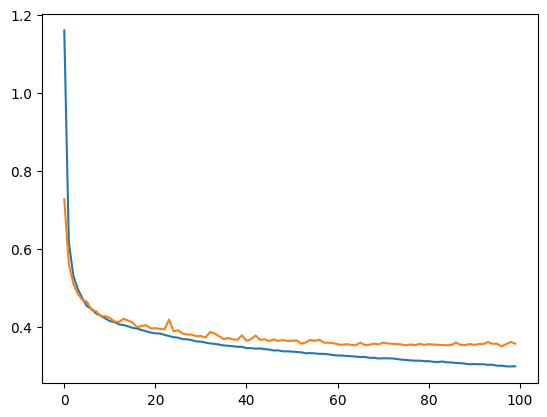

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [21]:
model_dm_bb.summary()

Model: "transformer_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Functional)       (None, None, 128)         1318784   
                                                                 
 decaymode_head (Functional  (None, 16)                1537168   
 )                                                               
                                                                 
Total params: 1537168 (5.86 MB)
Trainable params: 218384 (853.06 KB)
Non-trainable params: 1318784 (5.03 MB)
_________________________________________________________________


In [ ]:
model_dm_bb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)
history2 = model_dm_bb.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val)
)

Epoch 1/100
196/196 [==============================] - 56s 244ms/step - loss: 1.2484 - val_loss: 0.9857
Epoch 2/100
196/196 [==============================] - 46s 235ms/step - loss: 0.8240 - val_loss: 0.7151
Epoch 3/100
196/196 [==============================] - 46s 235ms/step - loss: 0.6544 - val_loss: 0.6081
Epoch 4/100
196/196 [==============================] - 46s 235ms/step - loss: 0.5740 - val_loss: 0.5617
Epoch 5/100
196/196 [==============================] - 46s 235ms/step - loss: 0.5397 - val_loss: 0.5628
Epoch 6/100
196/196 [==============================] - 46s 235ms/step - loss: 0.5183 - val_loss: 0.5294
Epoch 7/100
196/196 [==============================] - 46s 235ms/step - loss: 0.5041 - val_loss: 0.4980
Epoch 8/100
196/196 [==============================] - 46s 235ms/step - loss: 0.4858 - val_loss: 0.4995
Epoch 9/100
196/196 [==============================] - 46s 235ms/step - loss: 0.4765 - val_loss: 0.4977
Epoch 10/100
196/196 [==============================] - 46s 236m

In [ ]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])

In [ ]:
plt.plot(history.history["loss"], label="direct", color="black")
plt.plot(history2.history["loss"], label="OmniLearn backbone", color="red")
plt.legend()